
# Tumor Classification (Breast Cancer)

## Context
This notebook has as its main objective to develop a Machine Learning code with logistic regression using the `breast_cancer` dataset, native from `sklearn.datasets`.

## Business question
### Is it possible to predict whether a tumor is **malignant** (0) or **benign** (1) from 10 mean measurements (_mean_)?
            

## Dataset
- Source: Breast Cancer Wisconsin (Diagnostic) — via `sklearn.datasets.load_breast_cancer`.
- Size: 569 observations.
- Target: `target` (0 = malignant, 1 = benign).
- Attributes used: compact version with 10 *_mean*:
  - mean radius, mean texture, mean perimeter, mean area, mean smoothness,
  mean compactness, mean concavity, mean concave points, mean symmetry, mean fractal dimension.

**Notebook steps**

- Build a complete classification pipeline with **Logistic Regression**,

  - EDA
  - Pre-processing
  - Evaluation (Accuracy, Precision, Recall, F1, Confusion Matrix, ROC/AUC)
  - Interpretations

## Imports and Configurations

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Data and split/validation
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict, cross_val_score

# Pre-processing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, classification_report, average_precision_score
)

# Interpretation (odds ratio)
import statsmodels.api as sm

# Default settings
np.random.seed(42)
plt.rcParams['figure.figsize'] = (8, 5)

## Dataset loading and column selection

In [12]:

data = load_breast_cancer(as_frame=True)
df = data.frame.copy()

# Keep only *_mean columns (10 columns) + target
keep = [c for c in df.columns if ('mean' in c)] + ['target']
df = df[keep].copy()

# target: 0=malignant, 1=benign
df['target_label'] = df['target'].map({0: 'malignant', 1: 'benign'})

df.shape, df.head()


((569, 12),
    mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
 0        17.99         10.38          122.80     1001.0          0.11840   
 1        20.57         17.77          132.90     1326.0          0.08474   
 2        19.69         21.25          130.00     1203.0          0.10960   
 3        11.42         20.38           77.58      386.1          0.14250   
 4        20.29         14.34          135.10     1297.0          0.10030   
 
    mean compactness  mean concavity  mean concave points  mean symmetry  \
 0           0.27760          0.3001              0.14710         0.2419   
 1           0.07864          0.0869              0.07017         0.1812   
 2           0.15990          0.1974              0.12790         0.2069   
 3           0.28390          0.2414              0.10520         0.2597   
 4           0.13280          0.1980              0.10430         0.1809   
 
    mean fractal dimension  target target_label  
 0              

### IQR capping on variables (simple winsorization)


In [13]:
features_mean = [c for c in df.columns if ('mean' in c)]
def cap_iqr(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    return s.clip(lower=low, upper=high)

df[features_mean] = df[features_mean].apply(cap_iqr)

## 2) EDA — Exploratory Data Analysis

### What are the attributes (*features*)?

In [14]:

print("\nDataFrame information:\n")
print(df.info())

print("\nDescriptive statistics (numeric):\n")
df.describe().T



DataFrame information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mean radius             569 non-null    float64
 1   mean texture            569 non-null    float64
 2   mean perimeter          569 non-null    float64
 3   mean area               569 non-null    float64
 4   mean smoothness         569 non-null    float64
 5   mean compactness        569 non-null    float64
 6   mean concavity          569 non-null    float64
 7   mean concave points     569 non-null    float64
 8   mean symmetry           569 non-null    float64
 9   mean fractal dimension  569 non-null    float64
 10  target                  569 non-null    int64  
 11  target_label            569 non-null    object 
dtypes: float64(10), int64(1), object(1)
memory usage: 53.5+ KB
None

Descriptive statistics (numeric):



,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.062916,3.340025,6.981000,11.70000,13.37000,15.78000,21.900000
mean texture,569.0,19.254736,4.187510,9.710000,16.17000,18.84000,21.80000,30.245000
mean perimeter,569.0,91.543787,23.047218,43.790000,75.17000,86.24000,104.10000,147.495000
mean area,569.0,639.765202,305.343508,143.500000,420.30000,551.10000,782.70000,1326.300000
mean smoothness,569.0,0.096266,0.013685,0.057975,0.08637,0.09587,0.10530,0.133695
mean compactness,569.0,0.103222,0.049386,0.019380,0.06492,0.09263,0.13040,0.228620
mean concavity,569.0,0.086937,0.073900,0.000000,0.02956,0.06154,0.13070,0.282410
mean concave points,569.0,0.048552,0.037633,0.000000,0.02031,0.03350,0.07400,0.154535
mean symmetry,569.0,0.180734,0.026067,0.111200,0.16190,0.17920,0.19570,0.246400
mean fractal dimension,569.0,0.062604,0.006418,0.049960,0.05770,0.06154,0.06612,0.078750


### What is the target attribute?

It defines whether the tumor is **malignant** (0) or **benign** (1)

In [15]:
print(df.target)

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64


*Note: This dataset does not contain categorical variables, so there is no EDA for that type of variable.*

### Class distribution

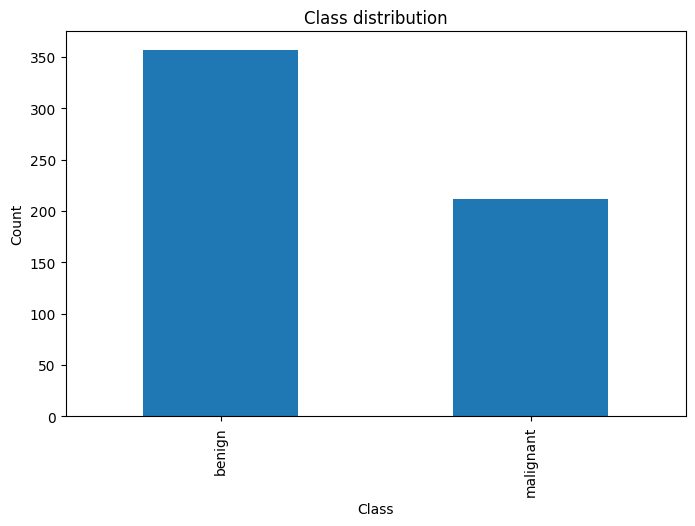

In [16]:
cls_counts = df['target_label'].value_counts()
ax = cls_counts.plot(kind='bar')
ax.set_title('Class distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.show()


### Correlation among the 10 features

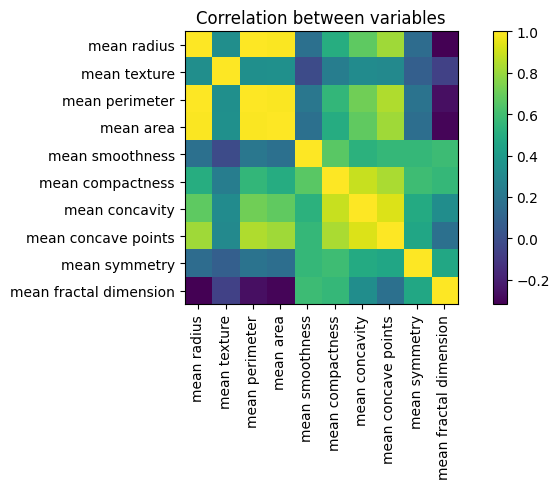

In [17]:

features_mean = [c for c in df.columns if (c.endswith('mean') or ('mean' in c))]
corr = df[features_mean].corr()

fig, ax = plt.subplots()
cax = ax.imshow(corr.values, interpolation='nearest')
ax.set_xticks(range(len(features_mean)))
ax.set_yticks(range(len(features_mean)))
ax.set_xticklabels(features_mean, rotation=90)
ax.set_yticklabels(features_mean)
fig.colorbar(cax)
ax.set_title('Correlation between variables')
plt.tight_layout()
plt.show()


#### Interpretation:

Larger lesions (radius/perimeter/area) and those with more irregular borders (concavity/concave points) tend to occur together.

This pattern is compatible with higher suspicion of malignancy. The map helps us see which attributes tend to co-occur and where the model can extract more signal.


## Binary model building

In [18]:
# Binary classification — Target: target (1=benign, 0=malignant)

# 1) Prepare dataset
data = df.copy().dropna(subset=['target'])

y = data['target'].astype(int)

# X without the target (and without target_label, if it exists, to avoid leakage)
drop_cols = [c for c in ['target', 'target_label'] if c in data.columns]
X = data.drop(columns=drop_cols)

# 2) Identify types
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# 3) Pré-processamento
numeric_prep = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Compatibilidade do OneHotEncoder entre versões:
try:
    categorical_prep = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
except TypeError:
    categorical_prep = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

preprocess = ColumnTransformer([
    ('num', numeric_prep, num_cols),
    ('cat', categorical_prep, cat_cols)
])

# Modelo de Regressão Logística (binário)
clf = LogisticRegression(
    solver='saga',
    penalty='l2',
    max_iter=5000,
    class_weight='balanced',
    random_state=42
)

# Full pipeline
pipe = Pipeline([
    ('prep', preprocess),
    ('clf', clf)
])

# 5) Stratified cross-validation (OOF)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_oof = cross_val_predict(pipe, X, y, cv=cv, method='predict', n_jobs=-1)
y_prob_oof = cross_val_predict(pipe, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

# 6) Train final model on 100% of the data
pipe.fit(X, y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['mean radius',
                                                   'mean texture',
                                                   'mean perimeter',
                                                   'mean area',
                                                   'mean smoothness',
                                                   'mean compactness',
                                                   'mean concavity',
                                                   'mean concave points',
                                                   'mean symmetry',
                                                   'mean fractal dimension']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='saga'))])

### Evaluation and interpretation — target (0 = malignant, 1 = benign)

In [19]:
# --- Main metrics
acc_scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
f1_scores  = cross_val_score(pipe, X, y, cv=cv, scoring='f1',       n_jobs=-1)

acc_mean, acc_std = acc_scores.mean(), acc_scores.std()
f1_mean,  f1_std  = f1_scores.mean(),  f1_scores.std()

roc_auc   = roc_auc_score(y, y_prob_oof)
acc_test  = accuracy_score(y, y_pred_oof)
bal_acc   = balanced_accuracy_score(y, y_pred_oof)
avg_prec  = average_precision_score(y, y_prob_oof)  # positive class = 1 (benign)

# --- Confusion matrix and report
cm = confusion_matrix(y, y_pred_oof, labels=[0, 1])
cm_df = pd.DataFrame(
    cm,
    index  = ['True: malignant (0)', 'True: benign (1)'],
    columns=['Pred: malignant (0)', 'Pred: benign (1)']
)

report = classification_report(
    y, y_pred_oof,
    target_names=['malignant (0)', 'benign (1)'],
    digits=3, zero_division=0
)

# --- Show Results
dist = pd.Series(y).value_counts().sort_index()

print("===============================================")
print("Performance of Binary Logistic Regression")
print("===============================================")
print(f"Target distribution (0=malignant, 1=benign): [{dist[0]} {dist[1]}]\n")

print(f"✅ Mean Accuracy (5-fold Cross-Validation): {acc_mean:.3f} ± {acc_std:.3f}")
print(f"✅ Mean F1-score (5-fold Cross-Validation): {f1_mean:.3f} ± {f1_std:.3f}")
print(f"✅ Overall Accuracy (OOF/combined test):      {acc_test:.3f}")
print(f"✅ Balanced Accuracy (OOF/combined test):     {bal_acc:.3f}")
print(f"✅ ROC-AUC (OOF/combined test):               {roc_auc:.3f}")
print(f"✅ PR-AUC / Average Precision (class 1=benign): {avg_prec:.3f}")

print("\nClassification Report (OOF/combined test):")
print(report)

print("Confusion Matrix:")
display(cm_df)

# --- Coefficient interpretation (final model on 100% of the data)
pipe.fit(X, y)

# Ensure list of feature names
if 'num_cols' not in locals():
    num_cols = X.select_dtypes(include=['number']).columns.tolist()

cat_names = []
if 'cat_cols' in locals() and len(cat_cols) > 0:
    ohe = pipe.named_steps['prep'].named_transformers_['cat'].named_steps['ohe']
    cat_names = list(ohe.get_feature_names_out(cat_cols))
feat_names = num_cols + cat_names

coefs = pipe.named_steps['clf'].coef_.ravel()
coef_tbl = (
    pd.DataFrame({'Variable': feat_names, 'Coefficient': coefs})
      .assign(abs_coef=lambda d: d['Coefficient'].abs())
      .sort_values('abs_coef', ascending=False)
)

print("\nTop most influential variables (positive class = 'benign'):")
display(coef_tbl.head(15)[['Variable', 'Coefficient']])

Performance of Binary Logistic Regression
Target distribution (0=malignant, 1=benign): [212 357]

✅ Mean Accuracy (5-fold Cross-Validation): 0.932 ± 0.015
✅ Mean F1-score (5-fold Cross-Validation): 0.945 ± 0.013
✅ Overall Accuracy (OOF/combined test):      0.931
✅ Balanced Accuracy (OOF/combined test):     0.929
✅ ROC-AUC (OOF/combined test):               0.985
✅ PR-AUC / Average Precision (class 1=benign): 0.990

Classification Report (OOF/combined test):
               precision    recall  f1-score   support

malignant (0)      0.899     0.920     0.909       212
   benign (1)      0.952     0.938     0.945       357

     accuracy                          0.931       569
    macro avg      0.925     0.929     0.927       569
 weighted avg      0.932     0.931     0.932       569

Confusion Matrix:


,Pred: malignant (0),Pred: benign (1)
True: malignant (0),195,17
True: benign (1),22,335



Top most influential variables (positive class = 'benign'):


,Variable,Coefficient
7,mean concave points,-1.442898
1,mean texture,-1.364825
3,mean area,-1.340289
6,mean concavity,-1.280704
4,mean smoothness,-0.956172
0,mean radius,-0.945978
2,mean perimeter,-0.836728
5,mean compactness,0.623707
8,mean symmetry,-0.373478
9,mean fractal dimension,0.135219


### Binary ROC curve

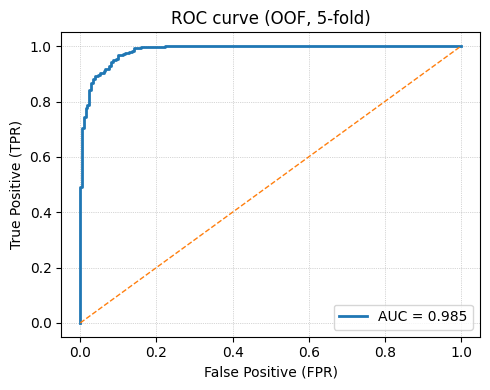

In [20]:
# y_prob_oof must exist; if not, generate it in the validation block
fpr, tpr, thresholds = roc_curve(y, y_prob_oof)
auc_val = roc_auc_score(y, y_prob_oof)

fig = plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc_val:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.title("ROC curve (OOF, 5-fold)")
plt.xlabel("False Positive (FPR)")
plt.ylabel("True Positive (TPR)")
plt.legend(loc="lower right")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()

plt.show()

#### Graphical interpretation — ROC curve

Interpretation of the ROC curve (OOF, 5-fold)
The ROC curve shows the trade-off between TPR (sensitivity/recall of the positive class) and FPR. Here we see a high area under the curve with a low false positive rate across a large range of thresholds.

Because the metric was computed with out-of-fold cross-validation (5-fold), the performance reflects generalization and not only the fit on the training data.
For practical use, the decision threshold should be chosen according to the cost of each type of error (which class you treat as positive) and its impact on the confusion matrix.


## Confusion matrix heatmap


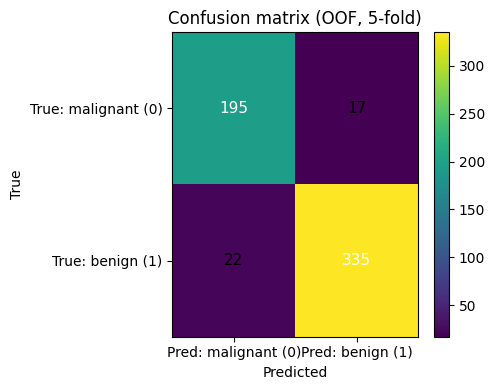

In [21]:
cm = confusion_matrix(y, y_pred_oof, labels=[0, 1])

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, interpolation='nearest', cmap='viridis', aspect='auto')
ax.set_title("Confusion matrix (OOF, 5-fold)")
fig.colorbar(im, ax=ax)

classes = ["malignant (0)", "benign (1)"]
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels([f"Pred: {c}" for c in classes])
ax.set_yticklabels([f"True: {c}" for c in classes])

# Value annotations
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=11
        )

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()
plt.show()

#### Interpretation of the confusion matrix
  
The confusion matrix summarizes how the model gets things right or wrong when comparing predicted class vs. true class.
The main diagonal shows the correct predictions.

In this case (OOF, 5-fold):

- 195 malignant cases (0) were correctly predicted as malignant (0).
- 335 benign cases (1) were correctly predicted as benign (1).
- Errors: 17 malignant cases predicted as benign (false “benign”) and 22 benign cases predicted as malignant (false “malignant”).

The model is well balanced between the classes, with accuracy ≈ 92.9% (Balanced Accuracy ≈ 92.9%) — consistent with the ROC curve (AUC ≈ 0.985).


## Barplot of top coefficients

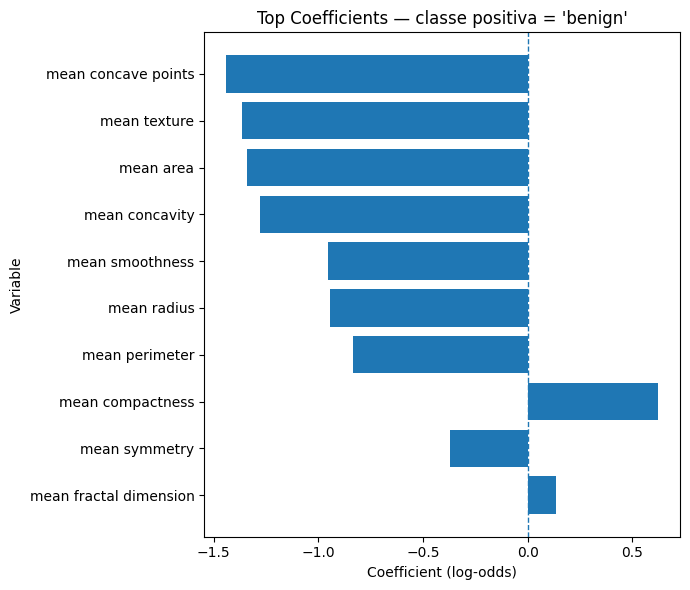

In [22]:
cat_names = []
if 'cat_cols' in locals() and len(cat_cols) > 0:
    ohe = pipe.named_steps['prep'].named_transformers_['cat'].named_steps['ohe']
    cat_names = list(ohe.get_feature_names_out(cat_cols))

# Ensure num_cols exists even if it is not in the current scope
if 'num_cols' not in locals():
    num_cols = X.select_dtypes(include=['number']).columns.tolist()

feat_names = num_cols + cat_names

coefs = pipe.named_steps['clf'].coef_.ravel()

coef_tbl = (
    pd.DataFrame({"variable": feat_names, "coef": coefs})
      .assign(abs_coef=lambda d: d["coef"].abs())
      .sort_values("abs_coef", ascending=False)
      .head(15)
      .iloc[::-1]
)

fig = plt.figure(figsize=(7, 6))
plt.barh(coef_tbl["variable"], coef_tbl["coef"])
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Top Coefficients — classe positiva = 'benign'")
plt.xlabel("Coefficient (log-odds)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

#### Graphical interpretation

  - **Most associated with malignancy (negative bars, larger magnitude):**

mean concave points, mean texture, mean area, mean concavity, mean smoothness, mean radius, mean perimeter.

From a clinical point of view, this points to more irregular/indented borders (concavity, concave points) and larger lesions (area, radius, perimeter) as strong indicators of malignancy.

  - **Most associated with benignity (positive bars):**

...


## Visualization of probabilities and decision

In [23]:
# Define decision threshold — default = 0.5
threshold = 0.5  # 0=malignant, 1=benign

# Build table with probabilities and final classification
prob_table = (
    pd.DataFrame({
        "prob_benign": y_prob_oof,                                # P(classe=1)
        "pred_class": (y_prob_oof >= threshold).astype(int),      # 1=benign, 0=malignant
        "true_class": y.astype(int)
    })
    .assign(
        pred_label=lambda d: d["pred_class"].map({0: "malignant", 1: "benign"}),
        true_label=lambda d: d["true_class"].map({0: "malignant", 1: "benign"}),
        margin_to_threshold=lambda d: (d["prob_benign"] - threshold).abs()
    )
    .sort_values("margin_to_threshold")
    .reset_index(drop=True)
)

print(f"Probability view with threshold = {threshold}:")
display(prob_table.head(10)[["prob_benign","pred_class","true_class","pred_label","true_label","margin_to_threshold"]])

Probability view with threshold = 0.5:


,prob_benign,pred_class,true_class,pred_label,true_label,margin_to_threshold
0,0.490993,0,1,malignant,benign,0.009007
1,0.510026,1,1,benign,benign,0.010026
2,0.510742,1,1,benign,benign,0.010742
3,0.489251,0,1,malignant,benign,0.010749
4,0.488418,0,0,malignant,malignant,0.011582
5,0.511732,1,1,benign,benign,0.011732
6,0.485563,0,1,malignant,benign,0.014437
7,0.515317,1,1,benign,benign,0.015317
8,0.521896,1,0,benign,malignant,0.021896
9,0.524877,1,1,benign,benign,0.024877


#### Interpretation of the probability table (sorted by distance to the threshold = 0.5)

  - `prob_benign` is the predicted probability of class 1 (benign).

  - `pred_class` applies the decision rule: predict 1 (benign) when `prob_benign ≥ 0.5`; otherwise predict 0 (malignant).

  - `margin_to_threshold` measures how close each case is to the decision threshold. Values near zero indicate more ambiguous cases (a very small change is enough for the predicted class to flip).

The excerpt shown has several observations with probabilities between ~0.49 and ~0.52. In this range:

  - Small oscillations (±0.01) change the decision from malignant ↔ benign.

  - It is normal to see both correct predictions and errors near the threshold (e.g., some true positives and true negatives are just above/below 0.5; with a small perturbation, other cases in this same range can become false negatives or false positives, and vice versa).

How to use this in practice

  - Define a “gray zone” (e.g., 0.48 ≤ `prob_benign` ≤ 0.52) for which you always request an additional examination/verification — these are the cases with the highest model uncertainty.

  - If the objective is to reduce the risk of labelling a malignant case as benign, you can lower the threshold (e.g., predict malignant already when `prob_benign < 0.55`), accepting an increase in false alarms (benign cases classified as malignant).

  - If the objective is to decrease false malignant predictions (avoid unnecessary exams/procedures), you can raise the threshold, accepting a greater chance of misclassifying benign cases as benign when they are actually malignant.

In summary, the table highlights where the model is “in doubt”. From a decision-making perspective, the threshold and any gray zone must consider the relative cost of each type of error (clinical/operational).


## Baseline vs. model

In [24]:
def metrics(y_true, y_pred, y_score):
    return dict(
        accuracy = accuracy_score(y_true,y_pred),
        precision= precision_score(y_true,y_pred),
        recall   = recall_score(y_true,y_pred),
        f1       = f1_score(y_true,y_pred),
        bal_acc  = balanced_accuracy_score(y_true,y_pred),
        roc_auc  = roc_auc_score(y_true,y_score)
    )

base_pred = np.repeat(np.bincount(y).argmax(), len(y))  # majority
base_prob = np.full(len(y), y.mean())

tbl = pd.DataFrame([
    {'model':'Baseline (majority)', **metrics(y, base_pred, base_prob)},
    {'model':'Logistic Regression',    **metrics(y, y_pred_oof, y_prob_oof)}
]).round(3)

display(tbl)

,model,accuracy,precision,recall,f1,bal_acc,roc_auc
0,Baseline (majority),0.627,0.627,1.000,0.771,0.500,0.500
1,Logistic Regression,0.931,0.952,0.938,0.945,0.929,0.985


## Conclusion

The Logistic Regression model trained with the 10 *_mean* variables showed high discriminative power (AUC ≈ 0.985) and overall accuracy ≈ 92.9%, with a difference in recall between malignant and benign cases of about ~6.2%. This is a fairly balanced performance between the classes.


### Business insights:

From an interpretability point of view, the standardized coefficients (log-odds) and odds ratios show how each variable is associated with malignant vs. benign outcomes. Even in the presence of multicollinearity, L2 regularization stabilizes the estimates, and for reading we prioritize a representative variable for each correlated group.

As a decision-support tool, the model is suitable as an instrument for triage/prioritization of cases and definition of “gray zones”, but it should not replace clinical judgment. The trade-off must be monitored by recall/precision for each class.


### Limitations and next steps:

- Academic dataset and subset of features (only *_mean*)
- Presence of multicollinearity (mitigated by L2)
- Probabilities are not calibrated and there is no external validation.
- As an evolution, we suggest cost-oriented threshold tuning, grid-search of C and class_weight targeting recall of class 0 (malignant).
- Calibration of probabilities and validation on external data before any assistive use.
